# Testing Several Stopping Criteria 

We are going to test several stopping criteria on different test functions. The stopping criteria that we are going to use and test are:- 
1. **Fixed Number of Iterations**: using a fixed number of iterations $K$ to stop the algorithm.
2. **Distance between successive iterates**: stop the algorithm when the difference between two successive iterations is less then some tolerance.
3. **KKT Conditions**: stop the algorithm by using Lemma 1 in the "Approximate-KKT stopping criterion when Lagrange multipliers are not available" article (Illustrated below).
4. **Duality Gap**: stop the algorithm when the dualit gap ($f(x) - g(u, v)$) is less than some tolerance. 


## $1^{st}$ Test Function 

$$\min_{x \in \mathbb{R}^n} \frac{1}{2} \|Ax - b\|^2$$

### Gradient Descent
As our test function is differentiable $f = \frac{1}{2} \|Ax - b\|^2$ then one of the basic algorithms that one can use is Gradient Descent (GD)

**Some Recalls:-**
1. *GD Algorithm*
$$x_{k + 1} = x_k - \gamma_k \nabla f(x_k)$$
2. *Theorem*
    * let $f$ be a convex, and differentiable function that has a minimizer $x^*$
    * $f$ has $L-$ Lipschitz continuous gradient ($\equiv ~ f$ is $L-$Smooth)
    
    Then, GD with constant step size $\gamma_k = \gamma = \frac{1}{L}$ satisfies 
    $$f(x_k) - f(x^*) \leq \frac{L\|x_0 - x^*\|^2}{2K}$$

#### Needed Libraries

In [2]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.linalg import null_space
from scipy.optimize import minimize
from Plot import plot

#### Parameters

In [4]:
n = int(input("Enter the dimension of your problem: "))
print(n)

10


In [5]:
xo = np.zeros(n)

#### Building the function 

In [6]:
A = np.random.randint(10, size = (n, n))
b = np.random.randint(10, size = (n))

In [7]:
def least_Square(X):
    return (0.5*np.linalg.norm(A@X - b)**2)

#### Function Derivative 
$$f'(x) = A^T (Ax - b)$$

In [8]:
def grad_LSquare(X):
    return A.T @ (A@X - b)

#### Dual Function

In [9]:
def dual_Fun(mu):
    return (mu@b - 0.5*np.linalg.norm(mu)**2)

### Remark 

If $g: \mathbb{R}^n \rightarrow \mathbb{R}$ is twice differentiable, then $g$ is $L$-Smooth if, and only if, $\forall \theta \in \mathbb{R}^n, ~~~ \mathbf{H}_g\preccurlyeq L . Id$

Applying it to our test function $f = \frac{1}{2} \|Ax - b\|^2$
$$\mathbf{H}_f = A^TA$$

Thus, $f$ is $L$-Smooth with $L = \lambda_{max}(A^TA)$

#### Finding the Eigenvalues of $A^TA$ 


In [10]:
A = A.astype(float)
D = np.dot(A.T,A)
eig = eigs(D)[0]
eig.sort()
print("Eigenvalues are ", eig)
lag_eig = eig[-1]
lag_eig = np.linalg.norm(lag_eig)
print("Largest eigenvalue is ", lag_eig)
sml_eig = eig[0]
sml_eig = np.linalg.norm(sml_eig) 
print("Smallest eigenvalue is ", sml_eig)

Eigenvalues are  [  48.47227764+0.j   67.07232329+0.j  133.74836338+0.j  184.08460118+0.j
  204.48877979+0.j 2218.96505363+0.j]
Largest eigenvalue is  2218.9650536342383
Smallest eigenvalue is  48.472277642632015


### The Minimizer $x^*$
As our test function is just a simple unconstrined function, we can find its minimzer analytical

$$f'(x) = A^T (Ax - b) = 0 \iff Ax - b = 0 \iff x^* = A^{-1}b$$ 
Where we assume that $A$ is invertible 

In [11]:
x_star = np.linalg.inv(A)@(b)
print("x_star = ", x_star)

x_star =  [ 0.05378959  1.10173121 -0.32401178 -0.86460233  1.37970754  0.90223016
 -1.23190758 -1.05002659  0.64759611  0.37357479]


### GD Algorithm 

In [12]:
def GD(xo = xo, ite = 1000, tol = 1e-4, x_fes = None, fun = least_Square, grad = grad_LSquare, dual_fun = dual_Fun,
                                                       smoothness_cst = lag_eig, x_star = x_star):
    
    x = xo 
    gamma = 1/smoothness_cst    # Constant Step Size
    F = []     # Function Values 
    D = []     # Distance to the optimum 
    
    Stopping_Criterion = input("Please, choose the Stopping Criterion you want:- Fixed Number of Iterations, Algorithmic Slow Down, KKT, or Duality Gap ")
# -----------------------------------------------------------------------    
    if (Stopping_Criterion == 'Fixed Number of Iterations'):
        print("GD with Fixed Number of Iterations is running :)")
        for k in range(ite):
            D.append(np.linalg.norm(x - x_star))
            F.append(fun(x))
            x = x - gamma*grad(x)
            
        return x, D, F
# -----------------------------------------------------------------------
    elif (Stopping_Criterion == 'Algorithmic Slow Down'):
        print("GD with Algorithmic Slow Down is running :)")
        x_prev = xo
        x = x - gamma*grad(x)
        D.append(np.linalg.norm(x - x_star))
        F.append(fun(x))
    
        while(np.linalg.norm(x - x_prev) >= tol):
            D.append(np.linalg.norm(x - x_star))
            F.append(fun(x))
            x_prev = x
            x = x - gamma*grad(x)
            
        return x, D, F
# ------------------------------------------------------------------------
    elif (Stopping_Criterion == 'KKT'):
        print("GD with KKT is running :)")
        G = grad(x)
        while(np.linalg.norm(G) >= tol):
            D.append(np.linalg.norm(x - x_star))
            F.append(fun(x))
            x = x - gamma*G
            G = grad(x)
            
        return x, D, F
#-----------------------------------------------------------------------------
    elif (Stopping_Criterion == 'Duality Gap'):
        print("GD with Duality Gap is running :)")
        dp = dual_fun(x_fes)
        while (fun(x) - dp >= tol):
            D.append(np.linalg.norm(x - x_star))
            F.append(fun(x))
            x = x - gamma*grad(x)
            
        return x, D, F

## *Time to Test Some Stopping Criteria!*

Our goal is to have an $\varepsilon-$Solution ($i.e. ~ $ a point $\hat{x} \in \mathbb{R}^n$ such that $f(\hat{x}) \leq \inf f + \varepsilon$)

For instance, let's admit that our $\varepsilon = 0.01$

In [13]:
eps = 1e-2

### 1. Fixed number of iterations

We can take $K = \frac{L f(x_0)}{\varepsilon \lambda_{\min}(\mathbf{A^TA})}$ as the fixed number of iterations. 

In [14]:
f_xo = least_Square(xo)
Nu = lag_eig*f_xo
De = eps*sml_eig

K = round(Nu/De)
print("# of Iterations = ", K)

# of Iterations =  773649


In [18]:
case1 = GD(xo, K)

GD with Fixed Number of Iterations is running :)


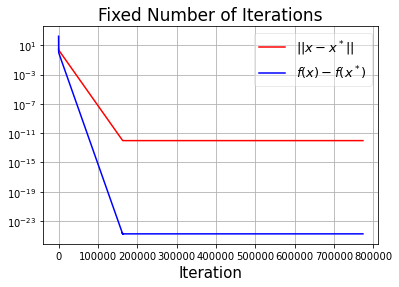

In [21]:
plot(case1[1], '$||x - x^*||$', case1[2], '$f(x) - f(x^*)$', 'Fixed Number of Iterations', simple = False)

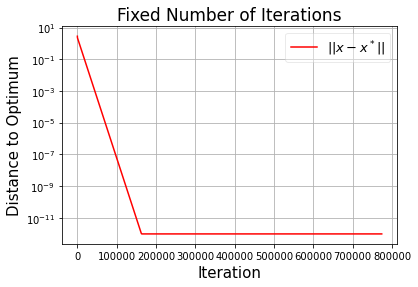

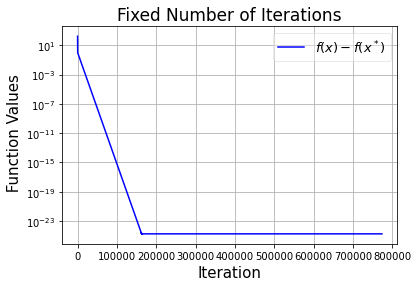

In [23]:
plot(case1[1], '$||x - x^*||$', case1[2], '$f(x) - f(x^*)$', 'Fixed Number of Iterations',
                 'Distance to Optimum', ' Function Values', simple = False)

### 2. Algorithmic Slow Down

$tol = \frac{2\varepsilon}{L}\sqrt{\frac{\lambda_{\min}(A^TA)}{2f(x_0)}}$

In [24]:
tol = 2*eps*np.sqrt((sml_eig/(2*f_xo)))/lag_eig
case2 = GD(tol = tol)


GD with Algorithmic Slow Down is running :)


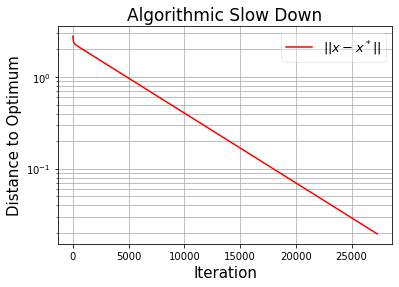

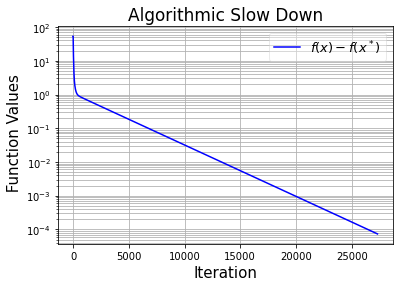

In [26]:
plot(case2[1], '$||x - x^*||$', case2[2], '$f(x) - f(x^*)$', 'Algorithmic Slow Down',
                 'Distance to Optimum', ' Function Values', simple = False)

### 3. KKT Conditions

$$tol = 2\varepsilon (\frac{\lambda_{\min}(A^TA)}{2f(x_0)})^{0.5}$$

In [27]:
tol = 2*eps*np.sqrt((sml_eig/(2*f_xo)))
print(tol)

0.007573878938868088


In [28]:
case3 = GD(tol = tol)

GD with KKT is running :)


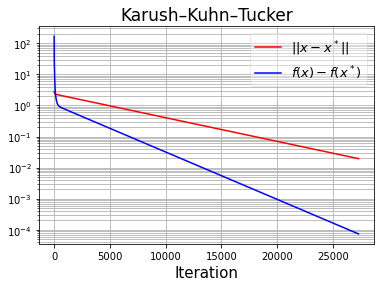

In [29]:
plot(case3[1], '$||x - x^*||$', case3[2], '$f(x) - f(x^*)$', 'Karush–Kuhn–Tucker', simple = False)

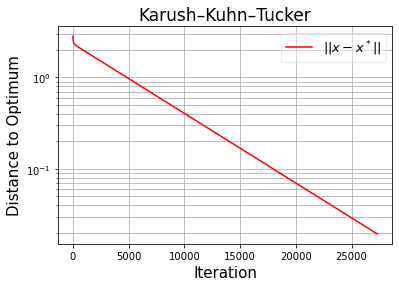

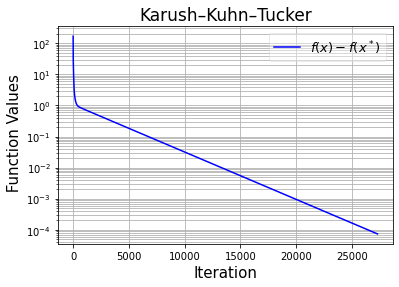

In [30]:
plot(case3[1], '$||x - x^*||$', case3[2], '$f(x) - f(x^*)$', 'Karush–Kuhn–Tucker','Distance to Optimum', ' Function Values', simple = False)

### 4. Duality Gap

 
$$\mathcal{P} = \min_{x} \frac{1}{2} \|Ax - b\|^2$$
is equivalent to:-
\begin{equation*}
\begin{split}
& \min_{x,z} \frac{1}{2} \|z\|^2 \\ 
& \text{S.t.} ~~ z = Ax - b
\end{split}
\end{equation*}

Define $\mathcal{L}(x, z, \mu) = \frac{1}{2} \|z\|^2 + \langle z - Ax + b, \mu \rangle$, then it's known that:-

$\mathcal{P} = \inf_{z, x} \sup_{\mu} \mathcal{L}(x, z, \mu)~$ and $~\mathcal{D} = \sup_{\mu} \inf_{x,z} \mathcal{L}(x, z, \mu)$

Thus, $\mathcal{D} = \sup_{\mu} \inf_{x,z} \frac{1}{2} \|z\|^2 + \langle z - Ax + b, \mu \rangle = \sup_{\mu} \langle b, \mu \rangle + \inf_{x,z} \langle z - Ax, \mu \rangle + \frac{1}{2} \|z\|^2$

Let $h(x, z) = \langle z - Ax, \mu \rangle + \frac{1}{2} \|z\|^2$

then, $$\nabla h = \begin{cases} \frac{\partial h}{\partial x} = A^T \mu \\ \frac{\partial h}{\partial z} = \mu + z \end{cases} $$ 
$\nabla h = 0 \iff \begin{cases} \frac{\partial h}{\partial x} = A^T \mu \\ \frac{\partial h}{\partial z} = \mu + z \end{cases} = 0 \iff \begin{cases} A^T\mu = 0 \\ z = - \mu  \end{cases} \iff \begin{cases} \mu \in \ker(A^T) \\ z = - \mu\end{cases}$

$h(x, z) = \langle z - Ax, \mu \rangle + \frac{1}{2} \|z\|^2 = \langle z, \mu \rangle - \langle x, A^T\mu \rangle + \frac{1}{2} \|z\|^2$

Thus, $h(x, -\mu) = -\|\mu\|^2 + \frac{1}{2} \|\mu\|^2 = \frac{-1}{2} \|\mu\|^2$

Hence, the dual problem is:- 
\begin{equation*}
\begin{split}
& \mathcal{D} = \max_{\mu \in \mathbb{R}^n} ~\langle \mu, b \rangle - \frac{1}{2} \|\mu\|^2 \\ 
& \text{S.t.} ~~~~~~~~~~ A^T\mu = 0 
\end{split}
\end{equation*}

***Thus, what we are going to do is to find a feasible point $\mu$ of $\mathcal{D}$ and use $f(x) - g(\mu)$ as our stopping criterion where $g(\mu) = \langle \mu, b \rangle - \frac{1}{2} \|\mu\|^2$***

#### *Finding a Feasible point $\mu$ of $\mathcal{D}$*

It's obvious that $\mu = 0$ does the jop for us. However, it'd be great to find another point (if any)

We are going to do that by looking at the $\ker (A^T)$

In [31]:
Ker = null_space(A.T)
print(Ker)

[]


$$\ker(A^T) = \{0\}$$

Thus, we'll take $\mu = 0$

In [32]:
mu = np.zeros(n)

In [33]:
case4 = GD(x_fes = mu, tol = eps)

GD with Duality Gap is running :)


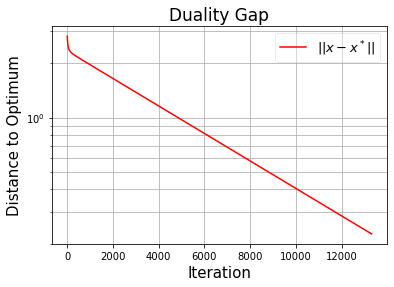

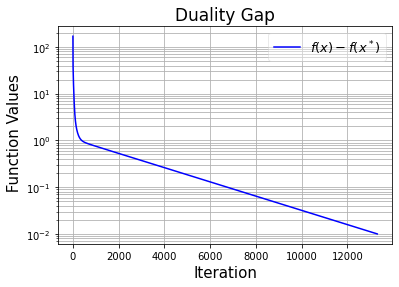

In [34]:
plot(case4[1], '$||x - x^*||$', case4[2], '$f(x) - f(x^*)$', 'Duality Gap', 'Distance to Optimum', ' Function Values', simple = False)